Setting Up the Environment

In [30]:
# Importing basic libraries pandas, numpy, sklearn or Scikit
# Pandas for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
# NumPy is the fundamental package for scientific computing in Python
#Scikit learn- Data modelling library for ML models


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Importing machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# For visualization
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


Loading the Dataset

In [31]:
# Load the dataset
data = pd.read_csv("london_merged.csv")

# Display the first few rows
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Explorimg the Data

In [32]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Summary statistics
data.describe()

# Check the columns
print("Columns in the dataset:", data.columns)

Missing values:
 timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64
Columns in the dataset: Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')


Preprocessing the Data

In [33]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Derive time_of_day from timestamp
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Late Evening"
    else:
        return "Night"

data['hour'] = data['timestamp'].dt.hour
data['time_of_day'] = data['hour'].apply(get_time_of_day)

# Normalize weather_code
weather_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 7: 5, 10: 6, 26: 7, 94: 8}
data['weather_code'] = data['weather_code'].map(weather_mapping)

# One-hot encode categorical columns
categorical_cols = ['season', 'time_of_day']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['t1', 't2', 'hum', 'wind_speed']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Drop unnecessary columns
data.drop(['timestamp', 'hour'], axis=1, inplace=True)

# Separate features and target variable
X = data.drop('cnt', axis=1)  # Features
y = data['cnt']  # Target variable



# Split the dataset into train (50%), validation (30%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)


# Confirm preprocessing and data split sizes
print("Preprocessing completed successfully!")
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Preprocessing completed successfully!
Training set size: (8707, 13)
Validation set size: (5224, 13)
Test set size: (3483, 13)


Profit Function Defining

In [34]:
# Constants for profit calculation
PURCHASE_PRICE = 590
RENTAL_PRICE = 25
HOLDING_COST_PERCENT = 0.2
HOLDING_COST_PER_BIKE = PURCHASE_PRICE * HOLDING_COST_PERCENT

# Function to calculate profit
def calculate_profit(actual_demand, predicted_demand):
    daily_holding_cost_per_bike = HOLDING_COST_PER_BIKE / 365
    total_profit = 0

    for actual, predicted in zip(actual_demand, predicted_demand):
        rental_income = RENTAL_PRICE * min(actual, predicted)
        overstock_cost = daily_holding_cost_per_bike * max(0, predicted - actual)
        understock_cost = RENTAL_PRICE * max(0, actual - predicted)
        total_profit += rental_income - overstock_cost - understock_cost

    return total_profit


Trainning the models

Model 1: Linear Regression

In [35]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate on validation set
val_preds_lr = lr.predict(X_val)
val_rmse_lr = np.sqrt(mean_squared_error(y_val, val_preds_lr))
val_profit_lr = calculate_profit(y_val, val_preds_lr)

print("Linear Regression - Validation RMSE:", val_rmse_lr)
print("Linear Regression - Validation Profit:", val_profit_lr)


Linear Regression - Validation RMSE: 827.1393079536939
Linear Regression - Validation Profit: 68750384.81605335


Model 2: Decision Tree (Optimized for RMSE)
Here I used first range from 2 to 20, then 2 to 30, saw that it converged and became flat

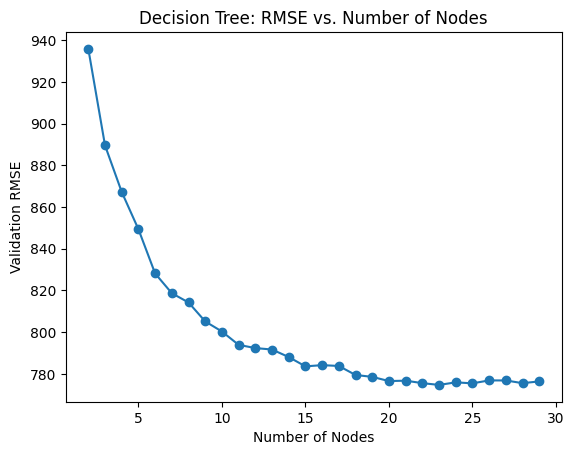

Best RMSE for Decision Tree: 774.7317958573749 with 23 nodes.
Profit for Decision Tree optimized for RMSE: 78602068.14580317 with 23 nodes.


In [44]:
# Decision Tree with RMSE optimization
best_rmse_dt, best_nodes_rmse = float('inf'), 0
rmse_values = []
nodes_range = range(2, 30)

for nodes in nodes_range:
    dt = DecisionTreeRegressor(max_leaf_nodes=nodes, random_state=42)
    dt.fit(X_train, y_train)
    val_preds = dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_values.append(rmse)

    if rmse < best_rmse_dt:
        best_rmse_dt = rmse
        best_nodes_rmse = nodes

#Calculate profit here
val_preds_mod=dt.predict(X_val)
best_nodes_profit1 = calculate_profit(y_val, val_preds_mod)

# Plot RMSE vs. Nodes
plt.plot(nodes_range, rmse_values, marker='o')
plt.title("Decision Tree: RMSE vs. Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Validation RMSE")
plt.show()

print("Best RMSE for Decision Tree:", best_rmse_dt, "with", best_nodes_rmse, "nodes.")
print("Profit for Decision Tree optimized for RMSE:", best_nodes_profit1, "with", best_nodes_rmse, "nodes.")


Model 3: Decision Tree (Optimized for Profit)

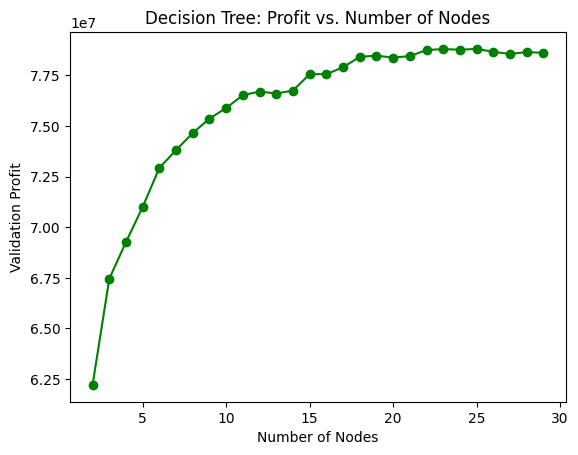

Best Profit for Decision Tree: 78799111.62440906 with 25 nodes.
RMSE for Decision Tree optimized for Profit: 776.4118975838591 with 25 nodes.


In [45]:
# Decision Tree with Profit optimization
best_profit_dt, best_nodes_profit = float('-inf'), 0
profit_values = []

for nodes in nodes_range:
    dt = DecisionTreeRegressor(max_leaf_nodes=nodes, random_state=42)
    dt.fit(X_train, y_train)
    val_preds = dt.predict(X_val)
    profit = calculate_profit(y_val, val_preds)
    profit_values.append(profit)
    if profit > best_profit_dt:
        best_profit_dt = profit
        best_nodes_profit = nodes

#Calculate RMSE here
val_preds_mod=dt.predict(X_val)
best_nodes_RMSE1 = np.sqrt(mean_squared_error(y_val, val_preds_mod))
# Plot Profit vs. Nodes
plt.plot(nodes_range, profit_values, marker='o', color='green')
plt.title("Decision Tree: Profit vs. Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Validation Profit")
plt.show()

print("Best Profit for Decision Tree:", best_profit_dt, "with", best_nodes_profit, "nodes.")
print("RMSE for Decision Tree optimized for Profit:", best_nodes_RMSE1, "with", best_nodes_profit, "nodes.")

Model 4: Neural Network (Optimized for RMSE)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


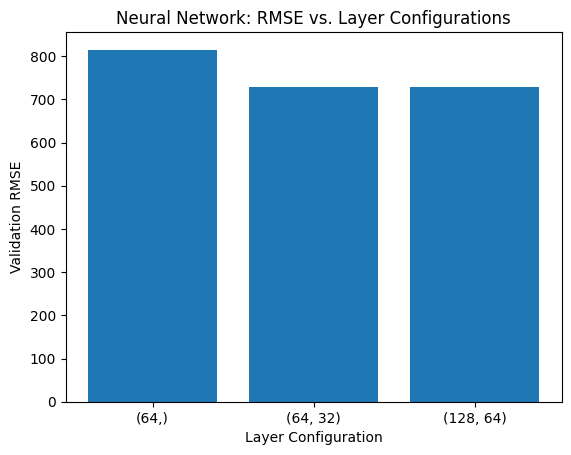

Best RMSE for Neural Network: 727.7111215576172 with layers: (128, 64)
Profit for NN optimized for RMSE: 78602068.14580317 with (128, 64) layers.


In [46]:
# Neural Network with RMSE optimization
best_rmse_nn, best_layers_rmse = float('inf'), None
rmse_values_nn = []
layer_configs = [(64,), (64, 32), (128, 64)]

for layers in layer_configs:
    nn = MLPRegressor(hidden_layer_sizes=layers, max_iter=500, random_state=42)
    nn.fit(X_train, y_train)
    val_preds = nn.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_values_nn.append(rmse)
    if rmse < best_rmse_nn:
        best_rmse_nn = rmse
        best_layers_rmse = layers


#Calculate profit here
val_preds_mod=dt.predict(X_val)
best_nodes_profit2 = calculate_profit(y_val, val_preds_mod)

# Plot RMSE vs. Layers
plt.bar(range(len(layer_configs)), rmse_values_nn, tick_label=[str(l) for l in layer_configs])
plt.title("Neural Network: RMSE vs. Layer Configurations")
plt.xlabel("Layer Configuration")
plt.ylabel("Validation RMSE")
plt.show()

print("Best RMSE for Neural Network:", best_rmse_nn, "with layers:", best_layers_rmse)
print("Profit for NN optimized for RMSE:", best_nodes_profit2, "with", best_layers_rmse, "layers.")

Model 5: Neural Network (Optimized for Profit)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


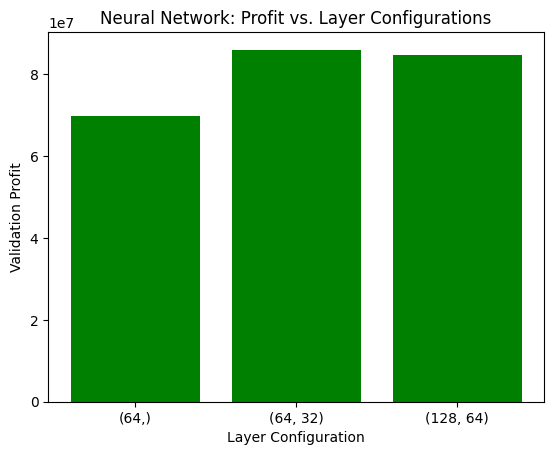

Best Profit for Neural Network: 85972722.30168547 with layers: (64, 32)
RMSE for NN optimized for Profit: 776.4118975838591 with (64, 32) nodes.


In [47]:
# Neural Network with Profit optimization
best_profit_nn, best_layers_profit = float('-inf'), None
profit_values_nn = []

for layers in layer_configs:
    nn = MLPRegressor(hidden_layer_sizes=layers, max_iter=500, random_state=42)
    nn.fit(X_train, y_train)
    val_preds = nn.predict(X_val)
    profit = calculate_profit(y_val, val_preds)
    profit_values_nn.append(profit)
    if profit > best_profit_nn:
        best_profit_nn = profit
        best_layers_profit = layers

#Calculate RMSE here
val_preds_mod=dt.predict(X_val)
best_nodes_RMSE2 = np.sqrt(mean_squared_error(y_val, val_preds_mod))

# Plot Profit vs. Layers
plt.bar(range(len(layer_configs)), profit_values_nn, tick_label=[str(l) for l in layer_configs], color='green')
plt.title("Neural Network: Profit vs. Layer Configurations")
plt.xlabel("Layer Configuration")
plt.ylabel("Validation Profit")
plt.show()

print("Best Profit for Neural Network:", best_profit_nn, "with layers:", best_layers_profit)
print("RMSE for NN optimized for Profit:", best_nodes_RMSE2, "with", best_layers_profit, "nodes.")

Evaluate on Test Set and Save Results

In [48]:
# Define models with the best hyperparameters
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree (RMSE)", DecisionTreeRegressor(max_leaf_nodes=best_nodes_rmse, random_state=42)),
    ("Decision Tree (Profit)", DecisionTreeRegressor(max_leaf_nodes=best_nodes_profit, random_state=42)),
    ("Neural Network (RMSE)", MLPRegressor(hidden_layer_sizes=best_layers_rmse, max_iter=500, random_state=42)),
    ("Neural Network (Profit)", MLPRegressor(hidden_layer_sizes=best_layers_profit, max_iter=500, random_state=42))
]

# List to store results
results = []

# Evaluate each model
for name, model in models:
    print(f"Evaluating model: {name}")

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predict on the test set
    test_preds = model.predict(X_test)

    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    # Calculate profit
    test_profit = calculate_profit(y_test, test_preds)

    # Store results
    results.append([name, test_rmse, test_profit])

# Save results to a DataFrame and CSV
results_df = pd.DataFrame(results, columns=["Model", "Test RMSE", "Test Profit"])
results_df.to_csv("model_results.csv", index=False)
print("Results saved successfully!")

# Display results
print(results_df)


Evaluating model: Linear Regression
Evaluating model: Decision Tree (RMSE)
Evaluating model: Decision Tree (Profit)
Evaluating model: Neural Network (RMSE)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating model: Neural Network (Profit)
Results saved successfully!
                     Model   Test RMSE   Test Profit
0        Linear Regression  813.845404  4.660065e+07
1     Decision Tree (RMSE)  769.177009  5.167055e+07
2   Decision Tree (Profit)  771.863866  5.164137e+07
3    Neural Network (RMSE)  722.940378  5.594918e+07
4  Neural Network (Profit)  722.727390  5.676076e+07


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
